In [2]:
%cd ..

E:\annotation_app


In [3]:
import sys
sys.path.append("backends/pysot")

In [4]:
import os
from argparse import Namespace

In [5]:
import cv2
import torch
import numpy as np
from glob import glob
from pathlib import Path

In [6]:
from image_array import MovieImageArray

In [7]:
from pysot.core.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker

## Modelのコンストラクト 

In [8]:
cfgarg = Namespace(config="backends/pysot/experiments/siammask_r50_l3/config.yaml",
                   snapshot="backends/pysot/experiments/siammask_r50_l3/model.pth",
                  )

In [9]:
cfg.merge_from_file(cfgarg.config)
cfg.CUDA = torch.cuda.is_available() and cfg.CUDA
device = torch.device("cpu")

In [ ]:
model = ModelBuilder()

In [ ]:
model.load_state_dict(torch.load(cfgarg.snapshot,
    map_location=lambda storage, loc: storage.cpu()))

In [ ]:
model.eval().to(device)
tracker = build_tracker(model)

## 動画の読み込み 

In [ ]:
movie_path = Path("sample_movie/sample_movie_1.mp4")
temp_path = Path("temp")
image_array = MovieImageArray(movie_path, is_temp=False, temp_dir=temp_path)

In [ ]:
image_array.read_movie(is_update=False)

## 最初の矩形 

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

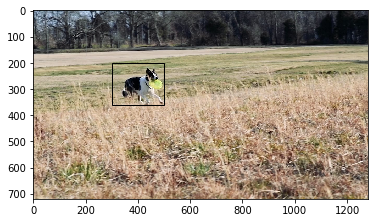

In [15]:
fig, ax = plt.subplots()

x1 = 300
y1 = 200
x2 = 500
y2 = 360

w = x2 - x1
h = y2 - y1

ax.imshow(image_array[0][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)

In [1]:
tracker.init(image_array[0], (x1,y1,w,h))

NameError: name 'tracker' is not defined

## 次の矩形を予測 

In [17]:
outputs = tracker.track(image_array[1])

e:\annotation_app\.venv\lib\site-packages\torch\nn\functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [18]:
outputs

{'bbox': [301.8713207672487,
  198.7392168643998,
  491.5417796710233,
  367.8576143974211],
 'best_score': 0.9997435,
 'mask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'polygon': [894.9928588867188,
  572.8248291015625,
  291.7467346191406,
  398.8115234375,
  354.22027587890625,
  182.236572265625,
  957.4664306640625,
  356.2498779296875]}

In [19]:
x1 = int(outputs["bbox"][0])
y1 = int(outputs["bbox"][1])
x2 = int(outputs["bbox"][2])
y2 = int(outputs["bbox"][3])


w = x2 - x1
h = y2 - y1

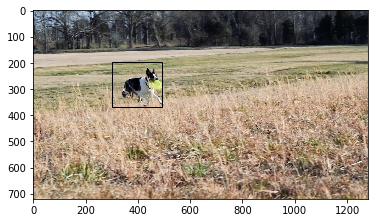

In [20]:
fig, ax = plt.subplots()

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)

In [21]:
polygon = outputs["polygon"]
polygon_array = np.array(polygon).astype(int).reshape((-1, 1, 2)).squeeze()
polygon_array

array([[894, 572],
       [291, 398],
       [354, 182],
       [957, 356]])

In [22]:
mask_img = (outputs["mask"]*255).astype(np.uint8)

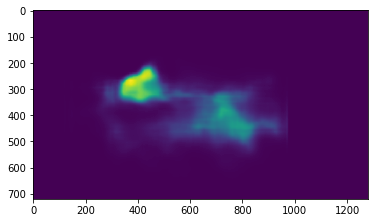

In [23]:
fig, ax = plt.subplots()

ax.imshow(mask_img)

この中から値の大きい領域を取得したい

どうやらポリゴンではうまくいかないらしい

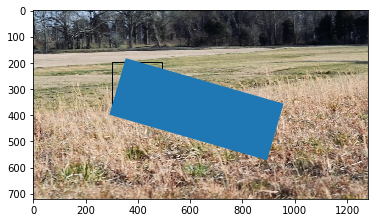

In [24]:
fig, ax = plt.subplots()

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)
polygon = patches.Polygon(polygon_array, closed=True)
ax.add_patch(polygon)

### 二値化とポリゴンの取得

In [25]:
ret2, img_otsu = cv2.threshold(mask_img, 0, 255, cv2.THRESH_OTSU)

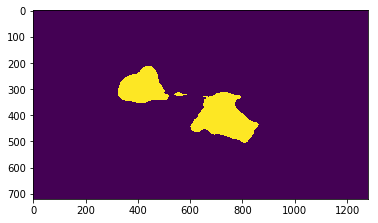

In [26]:
fig, ax = plt.subplots()
ax.imshow(img_otsu)

In [27]:
_, label_images, data, _ = cv2.connectedComponentsWithStats(img_otsu)

以下のように適切なラベルを求めればよい

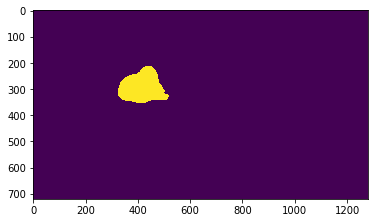

In [28]:
fig, ax = plt.subplots()
ax.imshow(label_images==1)

In [29]:
data # x,y,w,h,size

array([[     0,      0,   1280,    720, 874185],
       [   325,    211,    195,    144,  18147],
       [   600,    313,    263,    192,  28852],
       [   540,    314,     56,     14,    416]], dtype=int32)

このx,h,w,hを利用して領域内の平均値が大きいラベルをもとめる

In [48]:
max_value_mean = 0
max_value_index = 0

for i, one_data in enumerate(data[1:]):
    if one_data[4] > 100:  # 面積の下限
        one_label_bool_mask = label_images==(i+1)
        value_mean = (mask_img*one_label_bool_mask).sum()/one_label_bool_mask.sum()
        if value_mean > max_value_mean:
            max_value_mean = value_mean
            max_value_index = i
        

if data[max_value_index+1][4] > 100:  # 面積の下限
    _,max_contours,_ = cv2.findContours((label_images==(max_value_index+1)).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    max_contour = max_contours[0]
    max_polygon = max_contour.reshape(-1, 2)
    epsilon = 0.01*cv2.arcLength(max_polygon, True)
    max_approx = cv2.approxPolyDP(max_polygon, epsilon, False).squeeze()

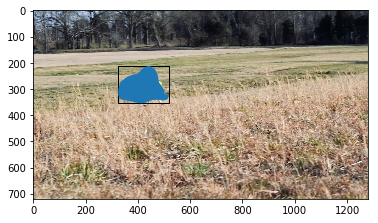

In [49]:
fig, ax = plt.subplots()

x = data[max_value_index+1][0]
y = data[max_value_index+1][1]
w = data[max_value_index+1][2]
h = data[max_value_index+1][3]

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x, y),w,h, fill=False)
ax.add_patch(rectangle)
polygon = patches.Polygon(max_approx, closed=True)
ax.add_patch(polygon)

### 以上を利用したtracker 

In [41]:
class SiamMaskTrackerV2():
    def __init__(self, is_cpu=True):
        is_cpu = not torch.cuda.is_available() and is_cpu
        cfgarg = Namespace(config="backends/pysot/experiments/siammask_r50_l3/config.yaml",
                           snapshot="backends/pysot/experiments/siammask_r50_l3/model.pth",
                          )
        cfg.merge_from_file(cfgarg.config)
        cfg.CUDA = not is_cpu
        device = torch.device("cuda" if not is_cpu else "cpu")
        model = ModelBuilder()
        model.load_state_dict(torch.load(cfgarg.snapshot,
                              map_location=lambda storage, loc: storage.cpu()))
        model.eval().to(device)
        self.tracker = build_tracker(model)
        
    def set_bbox(self, image, xyxy_dict=None, polygon_list=None):
        if xyxy_dict is None:
            raise Exception("SiameseMaskTracker set_bbox need xyxy_dict")
        x1 = xyxy_dict["x1"]
        y1 = xyxy_dict["y1"]
        x2 = xyxy_dict["x2"]
        y2 = xyxy_dict["y2"]
        
        self.tracker.init(image, (x1,y1,x2,y2))
        
    def get_bbox(self, image):
        outputs = self.tracker.track(image)
        mask_img = (outputs["mask"]*255).astype(np.uint8)
        _, img_otsu = cv2.threshold(mask_img, 0, 255, cv2.THRESH_OTSU)
        _, label_images, data, _ = cv2.connectedComponentsWithStats(img_otsu)
        
        max_value_mean = 0
        max_value_index = 0

        for i, one_data in enumerate(data[1:]):
            if one_data[4] > 100:  # 面積の下限
                one_label_bool_mask = label_images==(i+1)
                value_mean = (mask_img*one_label_bool_mask).sum()/one_label_bool_mask.sum()
                if value_mean > max_value_mean:
                    max_value_mean = value_mean
                    max_value_index = i


        out_dict = {}
        if data[max_value_index+1][4] > 100:  # 面積の下限
            _,max_contours,_ = cv2.findContours((label_images==(max_value_index+1)).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            max_contour = max_contours[0]
            max_polygon = max_contour.reshape(-1, 2)
            epsilon = 0.01*cv2.arcLength(max_polygon, True)
            max_approx = cv2.approxPolyDP(max_polygon, epsilon, False).squeeze()
            out_dict["polygon"] = [{"x":int(one_point[0]), "y":int(one_point[1])} for one_point in max_approx]
            out_dict["bbox_dict"] = {"x1":int(data[max_value_index+1][0]),
                                     "y1":int(data[max_value_index+1][1]),
                                     "x2":int(data[max_value_index+1][0]+data[max_value_index+1][2]),
                                     "y2":int(data[max_value_index+1][1]+data[max_value_index+1][3])
                                    }
        else:
            out_dict["polygon"] = None
            out_dict["bbox_dict"] = {"x1":None,"y1":None,"x2":None,"y2":None}
        
        return out_dict

In [42]:
box_tracker = SiamMaskTrackerV2()

In [43]:
x1 = 300
y1 = 200
x2 = 500
y2 = 360
xyxy_dict = {"x1":x1, "y1":y1, "x2":x2, "y2":y2}

In [44]:
box_tracker.set_bbox(image_array[0], xyxy_dict)

In [45]:
out_dict = box_tracker.get_bbox(image_array[1])

In [46]:
out_dict

{'polygon': [{'x': 444, 'y': 211},
  {'x': 335, 'y': 272},
  {'x': 325, 'y': 304},
  {'x': 331, 'y': 334},
  {'x': 406, 'y': 354},
  {'x': 516, 'y': 335},
  {'x': 518, 'y': 323},
  {'x': 500, 'y': 315},
  {'x': 468, 'y': 229},
  {'x': 445, 'y': 212}],
 'bbox_dict': {'x1': 325, 'y1': 211, 'x2': 520, 'y2': 355}}

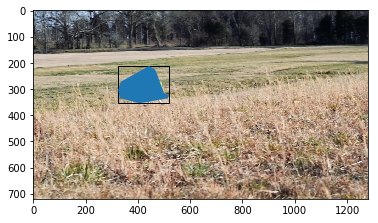

In [47]:
fig, ax = plt.subplots()

pos_dict = out_dict["bbox_dict"]
x1,y1,x2,y2 = pos_dict["x1"], pos_dict["y1"], pos_dict["x2"], pos_dict["y2"]

w = x2 - x1
h = y2 - y1

polygon_array = [[one_point["x"], one_point["y"]] for one_point in out_dict["polygon"]]

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)
polygon = patches.Polygon(polygon_array, closed=True)
ax.add_patch(polygon)